In [1]:
import scipy.io
import numpy as np
from scipy.ndimage import gaussian_filter
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt 
from matplotlib import cm as CM
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch
import torch.nn as nn

In [2]:
print(torch.cuda.device_count())

1


In [3]:


def image_to_matrix(path):
    img = cv2.imread(path,0)
    img = img.astype(np.float32, copy=False)
    ht = img.shape[0]
    wd = img.shape[1]
    ht_1 = int((ht/4)*4)
    wd_1 = int((wd/4)*4)
    img = cv2.resize(img,(wd_1,ht_1))
    img = img.reshape((1,1,img.shape[0],img.shape[1]))
    v = Variable(torch.from_numpy(img).type(torch.FloatTensor))
    v = v.to('cuda')

    return v


In [4]:
def generate_density_map_with_fixed_kernel(img,points,kernel_size=25,sigma=6.0):

    def guassian_kernel(size,sigma):
        rows=size[0] 
        cols=size[1]
        mean_x=int((rows-1)/2)
        mean_y=int((cols-1)/2)

        f=np.zeros(size)
        for x in range(0,rows):
            for y in range(0,cols):
                mean_x2=(x-mean_x)*(x-mean_x)
                mean_y2=(y-mean_y)*(y-mean_y)
                f[x,y]=(1.0/(2.0*np.pi*sigma*sigma))*np.exp((mean_x2+mean_y2)/(-2.0*sigma*sigma))
        return f

    [rows,cols]=[img.shape[0],img.shape[1]]
    d_map=np.zeros([rows,cols])
    f=guassian_kernel([kernel_size,kernel_size],sigma) # generate gaussian kernel with fixed size.
    normed_f=(1.0/f.sum())*f # normalization for each head.

    if len(points)==0:
        return d_map
    else:
        for p in points:
            r,c=int(p[0]),int(p[1])
            if r>=rows or c>=cols:
                continue
            for x in range(0,f.shape[0]):
                for y in range(0,f.shape[1]):
                    if x+((r+1)-int((f.shape[0]-1)/2))<0 or x+((r+1)-int((f.shape[0]-1)/2))>rows-1 \
                    or y+((c+1)-int((f.shape[1]-1)/2))<0 or y+((c+1)-int((f.shape[1]-1)/2))>cols-1:
                        continue
                    else:
                        d_map[x+((r+1)-int((f.shape[0]-1)/2)),y+((c+1)-int((f.shape[1]-1)/2))]+=normed_f[x,y]
    return d_map


In [5]:





def density_map(img_path,mat_path):
    img=plt.imread(img_path)
    mat = scipy.io.loadmat(mat_path)
    pts = mat["image_info"][0,0][0,0][0] 
    points=[]
    for p in pts:
        points.append([p[1],p[0]]) 
    density_map=generate_density_map_with_fixed_kernel(img,points)
    return density_map


In [6]:

import torch.nn as nn
from torch.autograd import Variable
import numpy as np

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, relu=True, same_padding=False, bn=False):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) / 2) if same_padding else 0
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [57]:



class MCNN(nn.Module):

    
    def __init__(self, bn=False):
        super(MCNN, self).__init__()
        
        self.branch1 = nn.Sequential(Conv2d( 1, 16, 9, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(16, 32, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(32, 16, 7, same_padding=True, bn=bn),
                                     Conv2d(16,  8, 7, same_padding=True, bn=bn))
        
        self.branch2 = nn.Sequential(Conv2d( 1, 20, 7, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(20, 40, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(40, 20, 5, same_padding=True, bn=bn),
                                     Conv2d(20, 10, 5, same_padding=True, bn=bn))
        
        self.branch3 = nn.Sequential(Conv2d( 1, 24, 5, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(24, 48, 3, same_padding=True, bn=bn),
                                     nn.MaxPool2d(2),
                                     Conv2d(48, 24, 3, same_padding=True, bn=bn),
                                     Conv2d(24, 12, 3, same_padding=True, bn=bn))
        
        self.fuse = nn.Sequential(Conv2d( 30, 1, 1, same_padding=True, bn=bn))
        
    def forward(self, im_data):
        x1 = self.branch1(im_data)
        x2 = self.branch2(im_data)
        x3 = self.branch3(im_data)
        x = torch.cat((x1,x2,x3),1)
        x = self.fuse(x)
        
        return x

In [8]:
class CustomMSELoss(nn.Module):
    def __init__(self):
        super(CustomMSELoss, self).__init__()

    def forward(self, predicted, target):
        # Flatten the matrices to vectors
        predicted_flat = predicted.view(-1)
        target_flat = target.view(-1)
        
        # Calculate the MSE loss
        mse_loss = torch.mean((predicted_flat - target_flat) ** 2)
        
        return mse_loss

In [62]:
import torch
import torch.nn as nn


class Branch1(nn.Module):
    def __init__(self, bn=False):
        super(Branch1, self).__init__()
        self.conv1 = Conv2d(1, 16, 9, same_padding=True, bn=bn)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = Conv2d(16, 32, 7, same_padding=True, bn=bn)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = Conv2d(32, 16, 7, same_padding=True, bn=bn)
        self.conv4 = Conv2d(16, 8, 7, same_padding=True, bn=bn)
        #self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.mean(x, dim=1, keepdim=False)
        x = x.squeeze()

        x = torch.transpose(x, 0, 1)
        return x

class Branch2(nn.Module):
    def __init__(self, bn=False):
        super(Branch2, self).__init__()
        self.conv1 = Conv2d(1, 20, 7, same_padding=True, bn=bn)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = Conv2d(20, 40, 5, same_padding=True, bn=bn)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = Conv2d(40, 20, 5, same_padding=True, bn=bn)
        self.conv4 = Conv2d(20, 10, 5, same_padding=True, bn=bn)
        #self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.mean(x, dim=1, keepdim=False)
        x = x.squeeze()

        x = torch.transpose(x, 0, 1)
        return x
    
class Branch3(nn.Module):
    def __init__(self, bn=False):
        super(Branch3, self).__init__()
        self.conv1 = Conv2d(1, 24, 5, same_padding=True, bn=bn)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = Conv2d(24, 48, 3, same_padding=True, bn=bn)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = Conv2d(48, 24, 3, same_padding=True, bn=bn)
        self.conv4 = Conv2d(24, 12, 3, same_padding=True, bn=bn)
        #self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = torch.mean(x, dim=1, keepdim=False)
        x = x.squeeze()

        x = torch.transpose(x, 0, 1)
        return x

In [10]:


import os

# Get the current working directory
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
parent_directory = os.path.join(parent_directory,'part_A')
parent_directory = os.path.join(parent_directory,'train_data')
parent_directory = os.path.join(parent_directory,'images')
parent_directory

files = os.listdir(parent_directory)
directories = []
for file in files:
    directories.append(os.path.join(parent_directory,file))


    


current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
parent_directory = os.path.join(parent_directory,'part_A')
parent_directory = os.path.join(parent_directory,'train_data')
parent_directory = os.path.join(parent_directory,'ground-truth')
parent_directory

files = os.listdir(parent_directory)
gt_directories = []
for file in files:
    gt_directories.append(os.path.join(parent_directory,file))

gt_directories.sort()
directories.sort()



    


In [11]:
import os

# Get the current working directory
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
parent_directory = os.path.join(parent_directory,'part_B')
parent_directory = os.path.join(parent_directory,'train_data')
parent_directory = os.path.join(parent_directory,'images')
parent_directory

files = os.listdir(parent_directory)

for file in files:
    directories.append(os.path.join(parent_directory,file))


    


current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
parent_directory = os.path.join(parent_directory,'part_B')
parent_directory = os.path.join(parent_directory,'train_data')
parent_directory = os.path.join(parent_directory,'ground-truth')
parent_directory

files = os.listdir(parent_directory)

for file in files:
    gt_directories.append(os.path.join(parent_directory,file))

gt_directories.sort()
directories.sort()

print(len(directories),len(gt_directories))

700 700


In [39]:
images = []
for i in range(len(directories)):
    # Assuming density_map function generates a tensor
    tensor = density_map(directories[i], gt_directories[i])
    h,w = tensor.shape[0],tensor.shape[1]
    
    tensor =  cv2.resize(tensor,(tensor.shape[0]//4,tensor.shape[1]//4))
    h1,w1 = tensor.shape[0],tensor.shape[1]
    tensor = tensor*(h*w/(h1*w1))
    
    tensor = torch.Tensor(tensor)
    tensor = tensor.to('cuda')  # Move tensor to GPU
    images.append(tensor)
    print(len(images))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [14]:

inputs = []

for i in range(len(directories)):

    image = image_to_matrix(directories[i])

    inputs.append(image.to('cuda'))
    print(i)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [84]:
print(inputs[0].shape,images[0].shape)


#print(np.sum(images[0].cpu().numpy()),np.sum(model(inputs[0]).detach().cpu().numpy()))

torch.Size([1, 1, 768, 1024]) torch.Size([256, 192])
1544.4252 0.2857586


Branch1(
  (conv1): Conv2d(
    (conv): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (relu): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(
    (conv): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU(inplace=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(
    (conv): Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU(inplace=True)
  )
  (conv4): Conv2d(
    (conv): Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (relu): ReLU(inplace=True)
  )
)

In [17]:
print(inputs[0].device,images[0].device)

cuda:0 cuda:0


In [81]:
# Define your loss function
criterion = nn.MSELoss()

# Define your optimizer
model = Branch1()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

# Assuming 'inputs' is your list of inputs and 'images' is your list of target images
# Assuming both 'inputs' and 'images' are PyTorch tensors or numpy arrays



# Assuming 'inputs' and 'images' have the same length
num_epochs = 200
for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    

    for i in range(len(images)):
        try:


            optimizer.zero_grad()  # Clear gradients

            # Forward pass
            output_image = model(inputs[i])

            loss = criterion(output_image, images[i])


            # Backward pass
            loss.backward()
            optimizer.step()
            


            
        except:
            pass

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    
           
      

Epoch [1/20], Loss: 0.022252654656767845
Epoch [2/20], Loss: 0.006718245800584555
Epoch [3/20], Loss: 0.003776242956519127
Epoch [4/20], Loss: 0.002291240496560931
Epoch [5/20], Loss: 0.00149337702896446
Epoch [6/20], Loss: 0.0011032327311113477
Epoch [7/20], Loss: 0.0009352268534712493
Epoch [8/20], Loss: 0.0008785458630882204
Epoch [9/20], Loss: 0.0008539087139070034
Epoch [10/20], Loss: 0.0008418465731665492
Epoch [11/20], Loss: 0.0008348003029823303
Epoch [12/20], Loss: 0.0008301417692564428
Epoch [13/20], Loss: 0.000826955190859735
Epoch [14/20], Loss: 0.0008247548248618841
Epoch [15/20], Loss: 0.0008232865948230028
Epoch [16/20], Loss: 0.0008224344346672297
Epoch [17/20], Loss: 0.0008219570736400783
Epoch [18/20], Loss: 0.0008216702844947577
Epoch [19/20], Loss: 0.0008214914705604315
Epoch [20/20], Loss: 0.0008213941473513842


In [131]:
torch.save(model.state_dict(), 'branch1.pth')

In [78]:
# Define your loss function
criterion = nn.MSELoss()

# Define your optimizer
model2 = Branch2()
model2 = model2.cuda()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-7)

# Assuming 'inputs' is your list of inputs and 'images' is your list of target images
# Assuming both 'inputs' and 'images' are PyTorch tensors or numpy arrays



# Assuming 'inputs' and 'images' have the same length
num_epochs = 200
for epoch in range(num_epochs):
    model2.train()  # Set the model to train mode
    

    for i in range(len(images)):
        try:


            optimizer.zero_grad()  # Clear gradients

            # Forward pass
            output_image = model2(inputs[i])

            loss = criterion(output_image, images[i])


            # Backward pass
            loss.backward()
            optimizer.step()
            


            
        except:
            pass

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    
           
      

Epoch [1/200], Loss: 0.00038446931284852326
Epoch [2/200], Loss: 0.0003497058351058513
Epoch [3/200], Loss: 0.0003171300340909511
Epoch [4/200], Loss: 0.0002867973526008427
Epoch [5/200], Loss: 0.0002581972803454846
Epoch [6/200], Loss: 0.00023132991918828338
Epoch [7/200], Loss: 0.00020636102999560535
Epoch [8/200], Loss: 0.0001832045818446204
Epoch [9/200], Loss: 0.00016201961261685938
Epoch [10/200], Loss: 0.0001428413816029206
Epoch [11/200], Loss: 0.00012562971096485853
Epoch [12/200], Loss: 0.00011021898535545915
Epoch [13/200], Loss: 9.682885865913704e-05
Epoch [14/200], Loss: 8.515013905707747e-05
Epoch [15/200], Loss: 7.518001075368375e-05
Epoch [16/200], Loss: 6.672156450804323e-05
Epoch [17/200], Loss: 5.96054014749825e-05
Epoch [18/200], Loss: 5.3590250900015235e-05
Epoch [19/200], Loss: 4.840227484237403e-05
Epoch [20/200], Loss: 4.3838514102390036e-05
Epoch [21/200], Loss: 3.978559107054025e-05
Epoch [22/200], Loss: 3.612664659158327e-05
Epoch [23/200], Loss: 3.2858908525

In [79]:
torch.save(model2.state_dict(), 'branch2.pth')

In [196]:
# Define your loss function
criterion = nn.MSELoss()

# Define your optimizer
model3 = Branch3()
model3 = model3.cuda()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-7)

# Assuming 'inputs' is your list of inputs and 'images' is your list of target images
# Assuming both 'inputs' and 'images' are PyTorch tensors or numpy arrays



# Assuming 'inputs' and 'images' have the same length
num_epochs = 200
for epoch in range(num_epochs):
    model3.train()  # Set the model to train mode
    

    for i in range(len(images)):
        try:


            optimizer.zero_grad()  # Clear gradients

            # Forward pass
            output_image = model3(inputs[i])

            loss = criterion(output_image, images[i])


            # Backward pass
            loss.backward()
            optimizer.step()
            


            
        except:
            pass

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
    
           
      

Epoch [1/200], Loss: 0.00023766126832924783
Epoch [2/200], Loss: 0.00022810112568549812
Epoch [3/200], Loss: 0.00021897487749811262
Epoch [4/200], Loss: 0.00021013688819948584
Epoch [5/200], Loss: 0.0002017416263697669
Epoch [6/200], Loss: 0.00019367611093912274
Epoch [7/200], Loss: 0.00018600467592477798
Epoch [8/200], Loss: 0.0001785646309144795
Epoch [9/200], Loss: 0.00017141838907264173
Epoch [10/200], Loss: 0.00016455433797091246
Epoch [11/200], Loss: 0.00015786774747539312
Epoch [12/200], Loss: 0.0001515159965492785
Epoch [13/200], Loss: 0.00014531683700624853
Epoch [14/200], Loss: 0.00013940308417659253
Epoch [15/200], Loss: 0.0001336162822553888
Epoch [16/200], Loss: 0.00012808280007448047
Epoch [17/200], Loss: 0.00012275901099201292
Epoch [18/200], Loss: 0.00011756337335100397
Epoch [19/200], Loss: 0.00011262306361459196
Epoch [20/200], Loss: 0.0001078457135008648
Epoch [21/200], Loss: 0.00010329403448849916
Epoch [22/200], Loss: 9.889647481031716e-05
Epoch [23/200], Loss: 9.4

In [197]:
torch.save(model3.state_dict(), 'branch3.pth')

In [ ]:
'''
d2 = final.branch2.state_dict()
for x in d2:
    print(d2[x].shape)

print(d2.keys())

print(d2['0.conv.weight'][0][0])
'''

In [203]:
'''
final.branch1.state_dict()['0.conv.weight'].copy_(d1['conv1.conv.weight'])
final.branch1.state_dict()['0.conv.weight'].copy_(d1['conv1.conv.bias'])
final.branch1.state_dict()['0.conv.weight'].copy_(d1['conv2.conv.weight'])
final.branch1.state_dict()['0.conv.weight'].copy_(d1['conv2.conv.bias'])
final.branch1.state_dict()['0.conv.weight'].copy_(d1['conv3.conv.weight'])
final.branch1.state_dict()['0.conv.weight'].copy_(d1['conv1.conv.weight'])

'''
final = MCNN()
d1_list = ['conv1.conv.weight', 'conv1.conv.bias', 'conv2.conv.weight', 'conv2.conv.bias', 'conv3.conv.weight', 'conv3.conv.bias', 'conv4.conv.weight', 'conv4.conv.bias']

d2 = ['0.conv.weight', '0.conv.bias', '2.conv.weight', '2.conv.bias', '4.conv.weight', '4.conv.bias', '5.conv.weight', '5.conv.bias']

for i in range(8):
    final.branch1.state_dict()[d2[i]].copy_(d1[d1_list[i]])


In [204]:

d1 = model2.state_dict()
for i in range(8):
    final.branch2.state_dict()[d2[i]].copy_(d1[d1_list[i]])

In [205]:
d1 = model3.state_dict()
for i in range(8):
    final.branch3.state_dict()[d2[i]].copy_(d1[d1_list[i]])

In [ ]:
# Define your loss function
criterion = nn.MSELoss()
#final = MCNN()
final = final.cuda()
optimizer = torch.optim.Adam(final.parameters(), lr=1e-5)

# Assuming 'inputs' is your list of inputs and 'images' is your list of target images
# Assuming both 'inputs' and 'images' are PyTorch tensors or numpy arrays



# Assuming 'inputs' and 'images' have the same length
final.train()
num_epochs = 250
for epoch in range(num_epochs):
      # Set the model to train mode
    

    for i in range(len(images)):
        try:


            optimizer.zero_grad()  # Clear gradients

            # Forward pass
            output_image = final(inputs[i])
            output_image = torch.tarnspose(output_image.squeeze(),(0,1))
            

            loss = criterion(output_image, images[i])


            # Backward pass
            loss.backward()
            optimizer.step()
            


            
        except:
            pass

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

In [227]:
torch.save(final.state_dict(), 'final_trained.pth')

In [88]:

MODEL = MCNN()
MODEL.load_state_dict(torch.load('final_trained.pt'))

<All keys matched successfully>

----------------- (1, 1, 192, 256) torch.Size([1, 1, 768, 1024])
----------------- (1, 1, 178, 256) torch.Size([1, 1, 713, 1024])
----------------- (1, 1, 166, 250) torch.Size([1, 1, 664, 1000])
----------------- (1, 1, 186, 256) torch.Size([1, 1, 746, 1024])
----------------- (1, 1, 170, 256) torch.Size([1, 1, 683, 1024])
----------------- (1, 1, 192, 256) torch.Size([1, 1, 768, 1024])
----------------- (1, 1, 147, 256) torch.Size([1, 1, 590, 1024])
----------------- (1, 1, 116, 175) torch.Size([1, 1, 465, 700])
----------------- (1, 1, 134, 200) torch.Size([1, 1, 536, 800])
----------------- (1, 1, 170, 256) torch.Size([1, 1, 683, 1024])
----------------- (1, 1, 171, 256) torch.Size([1, 1, 686, 1024])
----------------- (1, 1, 170, 256) torch.Size([1, 1, 680, 1024])
----------------- (1, 1, 186, 256) torch.Size([1, 1, 747, 1024])
----------------- (1, 1, 161, 256) torch.Size([1, 1, 645, 1024])
8.267797567158155


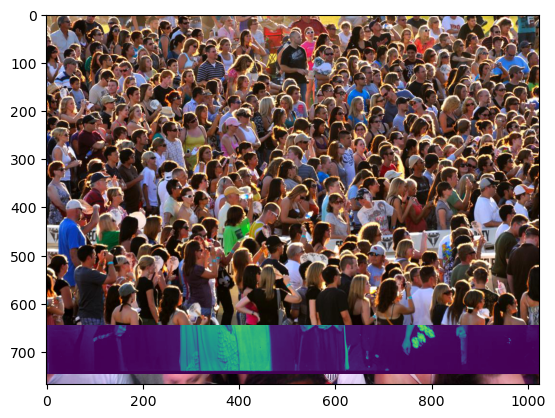

In [89]:
MODEL = MODEL.cuda()
a = 0
for i in range(1,15):
    img = cv2.imread('IMG_' + str(i) + '.jpg',0)
    img = img.astype(np.float32, copy=False)
    ht = img.shape[0]
    wd = img.shape[1]
    ht_1 = int((ht/4)*4)
    wd_1 = int((wd/4)*4)
    img = cv2.resize(img,(wd_1,ht_1))
    img = img.reshape((1,1,img.shape[0],img.shape[1]))
    v = Variable(torch.from_numpy(img).type(torch.FloatTensor))
    v = v.to('cuda')
    OUT = MODEL(v)
    OUT = OUT.detach().to('cpu').numpy()
    


    test = Image.open('IMG_' + str(i) + '.jpg')
    plt.imshow(test)
    plt.plot()
    print('-----------------',OUT.shape,v.shape)
    density = density_map('IMG_' + str(i) + '.jpg','GT_IMG_' + str(i) + '.mat')
    transform = transforms.ToTensor()
    test = transform(test)
    test = test.to('cuda')
    a += abs(np.sum(OUT)- np.sum(density))/np.sum(density)

print(a)

-----------------
260.6878577843282


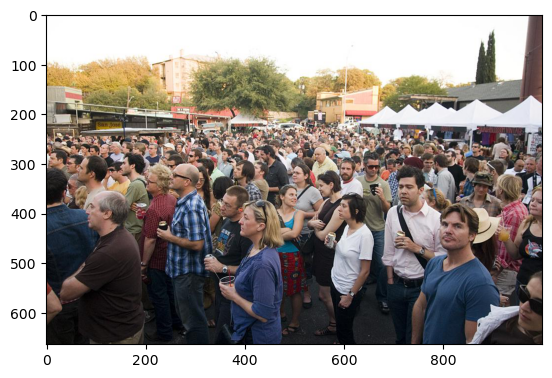